In [64]:
import torch
from torch import nn

import torchtext
from torchtext import datasets
from torchtext import data
from torchtext.datasets import IMDB

import matplotlib.pyplot as plt
import numpy as np
import spacy
import random
from timeit import default_timer as timer

In [2]:
print("Torch version:", torch.__version__)
print("TorchText version:", torchtext.__version__)

Torch version: 2.8.0+cu128
TorchText version: 0.6.0


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 5070


# Getting data ready

## Load dataset

Dataset Being used is from https://ai.stanford.edu/~amaas/data/sentiment/

In [4]:
nlp = spacy.load("en_core_web_lg")

#need to create this function to tokenize since i am using an old torchtext version 0.6.0
def tokenize_fn(text):
    return [token.text for token in nlp.tokenizer(text)]

In [5]:
train_text_field = data.Field(sequential=True, lower=True, tokenize=tokenize_fn, include_lengths=True)
train_label_field = data.Field(sequential=False, use_vocab=True, unk_token=None)

In [6]:
# Load IMDB dataset
train_dataset, test_dataset = datasets.IMDB.splits(
    text_field=train_text_field,
    label_field=train_label_field
)


train_dataset, validation_dataset = train_dataset.split(
                                                        split_ratio=0.8,
                                                        random_state=random.seed(43)
)

### Understanding data

In [7]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(20000, 5000, 25000)

In [8]:
first_example = train_dataset[0]

In [13]:
print("Text tokens:", first_example.text[0:5])
print("Full Review:", " ".join(first_example.text[0:5]))
print("Label:", first_example.label)

Text tokens: ['midnight', 'cowboy', 'made', 'a', 'big']
Full Review: midnight cowboy made a big
Label: pos


## Create dataloaders

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
train_dataset

In [16]:
train_text_field.build_vocab(train_dataset)
train_label_field.build_vocab(train_dataset)


In [17]:
BATCH_SIZE = 32

train_iter = data.BucketIterator(
                                 dataset=train_dataset, 
                                 batch_size = BATCH_SIZE, 
                                 sort_key=lambda x: len(x.text), #sort so batches require less padding
                                 sort_within_batch=True,
                                 device = device)

validation_iter = data.BucketIterator(
                                 dataset=validation_dataset, 
                                 batch_size = BATCH_SIZE, 
                                 sort_key=lambda x: len(x.text), #sort so batches require less padding
                                 sort_within_batch=True,
                                 device = device)

test_iter = data.BucketIterator(
                                 dataset=test_dataset, 
                                 batch_size = BATCH_SIZE, 
                                 sort_key=lambda x: len(x.text), #sort so batches require less padding
                                 sort_within_batch=True,
                                 device = device)

In [18]:
print(f'Length of train_iter: {len(train_iter)} batches of {BATCH_SIZE}')

Length of train_iter: 625 batches of 32


In [19]:
len(train_iter), len(validation_iter), len(test_iter)

(625, 157, 782)

In [20]:
#let's see what is in train_iter
first_batch = next(iter(train_iter))
first_batch


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.cuda.LongTensor of size 795x32 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [21]:
first_batch_features, first_batch_lengths = first_batch.text
first_batch_labels = first_batch.label

In [22]:
first_batch_features.shape, first_batch_lengths.shape, first_batch_labels.shape

(torch.Size([795, 32]), torch.Size([32]), torch.Size([32]))

In [24]:
first_batch_features[:,1][0:5]

tensor([   65,     2,   716,    25, 13579], device='cuda:0')

In [25]:
torch.manual_seed(26)
random_index = torch.randint(0, 32, size=[1]).item()
print(random_index)

review, label = first_batch_features[:,random_index], first_batch_labels[random_index]

21


Each word is assigned an index

In [30]:
string = ""
for word in [train_text_field.vocab.itos[index] for index in review]:
    # print(index)
    string += word + " "

print(string[0:54])

young mr. lincoln marks the first film of the director


## Mapping vocab to nlp

I need to confirm that spacy shares the same vocab space

In [31]:
nlp.vocab.strings['chances']

15039355625730079975

In [33]:
nlp("chances")[0].vector[0:5]   # returns a vector (nonzero if it’s in the pretrained vectors)

array([-0.14905 ,  0.25543 , -0.37928 ,  0.030789, -0.15589 ],
      dtype=float32)

In [35]:
train_text_field.vocab.itos[0:5]

['<unk>', '<pad>', 'the', ',', '.']

In [36]:
for token in train_text_field.vocab.itos[:6]:
    print(token)
    print(f'{nlp(token).vector[:5]}')
    print('\n')

<unk>
[ 0.023091    0.20018685 -0.12443933 -0.11972667  0.48589635]


<pad>
[ 0.07241767  0.32118002 -0.14560632 -0.04326934  0.24734968]


the
[ 0.27204  -0.06203  -0.1884    0.023225 -0.018158]


,
[-0.082752  0.67204  -0.14987  -0.064983  0.056491]


.
[ 0.012001  0.20751  -0.12578  -0.59325   0.12525 ]


and
[-0.18567   0.066008 -0.25209  -0.11725   0.26513 ]




In [37]:
emb_dim = nlp.vocab.vectors_length
vocab_size = len(train_text_field.vocab)

In [38]:
nlp.vocab

In [39]:
embedding_matrix = torch.empty((vocab_size,emb_dim))
#map indices from torchtext to spacy
for index, token in enumerate(train_text_field.vocab.itos):
    embedding_matrix[index] = torch.tensor(nlp.vocab[token].vector, device=device, dtype=torch.float)

embedding_matrix.shape


torch.Size([90636, 300])

Now, each index in train_text_field.vocab.itos is mapped to a length 300 vector embedding

In [40]:
embedding_matrix[2][:5], nlp.vocab['the'].vector[:5]

(tensor([ 0.2720, -0.0620, -0.1884,  0.0232, -0.0182]),
 array([ 0.27204 , -0.06203 , -0.1884  ,  0.023225, -0.018158],
       dtype=float32))

# Creating Model_0 (Bi-LSTM based)

In [41]:
class Model_0(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze=True)
        

    def forward(self, input_indices):
        word_embedding = self.embedding(input_indices)
        return word_embedding

In [42]:
model_0 = Model_0(embedding_matrix).to(device)

In [43]:
testing_embedding = model_0(torch.tensor(train_text_field.vocab.stoi[2]).to(device))

In [44]:
testing_embedding.shape

torch.Size([300])

In [45]:
torch.equal(testing_embedding, embedding_matrix[train_text_field.vocab.stoi[2]].to(device))

True

In [51]:
#Check if embedding works for multiple words
count = 0
for index, token in enumerate(train_text_field.vocab.itos):
    if(count ==5):
        break

    test_embedding = model_0(torch.tensor(train_text_field.vocab.stoi[token]).to(device))    
    actual_embedding = torch.tensor(nlp.vocab[token].vector, device=device, dtype=torch.float)
    print(f'{token=}')
    print(f'Word index = {torch.tensor(train_text_field.vocab.stoi[token])}')
    print(f'Model Embedding= {test_embedding[:5]}')
    print(f'Actual Embedding= {actual_embedding[:5]}')
    print(f'Embeddings are the same: {torch.equal(test_embedding, actual_embedding)}')

    count+=1
    print('\n')


token='<unk>'
Word index = 0
Model Embedding= tensor([0., 0., 0., 0., 0.], device='cuda:0')
Actual Embedding= tensor([0., 0., 0., 0., 0.], device='cuda:0')
Embeddings are the same: True


token='<pad>'
Word index = 1
Model Embedding= tensor([0., 0., 0., 0., 0.], device='cuda:0')
Actual Embedding= tensor([0., 0., 0., 0., 0.], device='cuda:0')
Embeddings are the same: True


token='the'
Word index = 2
Model Embedding= tensor([ 0.2720, -0.0620, -0.1884,  0.0232, -0.0182], device='cuda:0')
Actual Embedding= tensor([ 0.2720, -0.0620, -0.1884,  0.0232, -0.0182], device='cuda:0')
Embeddings are the same: True


token=','
Word index = 3
Model Embedding= tensor([-0.0828,  0.6720, -0.1499, -0.0650,  0.0565], device='cuda:0')
Actual Embedding= tensor([-0.0828,  0.6720, -0.1499, -0.0650,  0.0565], device='cuda:0')
Embeddings are the same: True


token='.'
Word index = 4
Model Embedding= tensor([ 0.0120,  0.2075, -0.1258, -0.5932,  0.1252], device='cuda:0')
Actual Embedding= tensor([ 0.0120,  0.207

## Continuing Model_0

Now that I know that the embeddings are correct, I can add in packing to make computation more efficient

In [52]:
class Model_01(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=1) #added padding_idx = 1 to not affect gradient
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        #use pack_padded_sequence in order to make computation efficient
        packed_embedding = nn.utils.rnn.pack_padded_sequence(enforce_sorted=False, input=word_embedding, lengths=input_lengths.cpu())
        return word_embedding, packed_embedding

In [53]:
model_01 = Model_01(embedding_matrix).to(device)
model_01

Model_01(
  (embedding): Embedding(90636, 300, padding_idx=1)
)

In [ ]:
testing_embedding_01, testing_packed_embeddings_01 = model_01(first_batch_features.to(device), first_batch_lengths)

In [57]:
testing_embedding_01.shape, testing_packed_embeddings_01.data.shape

(torch.Size([795, 32, 300]), torch.Size([24470, 300]))

In [59]:
# Take the original batch before packing
print("Original batch shape:", first_batch_features.shape)

# See one sequence with padding included
print("One padded sequence:", first_batch_features[:, 2][0:5])

# Now check the packed data length vs the sum of true lengths
print("Sum of true lengths:", first_batch_lengths.sum().item())
print("Packed tensor shape:", testing_packed_embeddings_01.data.shape)


Original batch shape: torch.Size([795, 32])
One padded sequence: tensor([1842,    8,  511, 7548,  105], device='cuda:0')
Sum of true lengths: 24470
Packed tensor shape: torch.Size([24470, 300])


Since sum of all the lengths and packed tensor are the same, I am confident that we removed the padding correctly

## Adding in the LSTM and Classifier

In [60]:
class Model_02(nn.Module):
    def __init__(self, emb_matrix):
        super().__init__()
        #embed the index corresponding to the number
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=1) #added padding_idx = 1 to not affect gradient

        #feed batches into LSTM
        self.forward_and_backward_LSTM = nn.LSTM(input_size=300, #embedding dimension
                                    hidden_size=256, #hyperparameter 
                                    num_layers=1,
                                    bidirectional=True,
                                    batch_first=False
                                    )

        self.classifier = nn.Sequential(
                                        nn.Linear(in_features=256*2*3, out_features=256*2*3),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(in_features=256*2*3, out_features=1)
                                        )
        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        #use pack_padded_sequence in order to make computation efficient
        packed_embedding = nn.utils.rnn.pack_padded_sequence(enforce_sorted=False, input=word_embedding, lengths=input_lengths.cpu())

        #pass through LSTM
        packed_output, (hn, cn) = self.forward_and_backward_LSTM(packed_embedding) #(seq_len, batch, hidden_size*2)
        
        #concatenate foward and backward hidden states
        h_final = torch.cat((hn[0], hn[1]), dim=1) # (batch_size, hidden_size*2)
        #Max and mean pooling
        unpacked_output, lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        mean_pool = torch.mean(unpacked_output, dim=0)
        max_pool, _ = torch.max(unpacked_output, dim=0)

        #combine
        features_pre_classification = torch.cat([h_final, mean_pool, max_pool], dim=1) #(batch_size, hidden_size*2*3)

        res = self.classifier(features_pre_classification).squeeze(dim=1)

        return res

I decided to choose 256 as the hidden_size because of my embedding dimension being 300, dataset size, and the modern gpu I have

In [61]:
model_02 = Model_02(embedding_matrix).to(device)
model_02

Model_02(
  (embedding): Embedding(90636, 300, padding_idx=1)
  (forward_and_backward_LSTM): LSTM(300, 256, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=1536, out_features=1536, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1536, out_features=1, bias=True)
  )
)

In [62]:
res = model_02(first_batch_features.to(device), first_batch_lengths)
res.shape

torch.Size([32])

In [63]:
res

tensor([ 0.0197,  0.0672,  0.0541,  0.0442, -0.0464, -0.0012,  0.0327, -0.0128,
         0.0606, -0.0469,  0.0381,  0.0420, -0.0302,  0.0644,  0.0244, -0.0136,
         0.0288,  0.0178, -0.0125,  0.0570,  0.0241,  0.0277,  0.0644, -0.0129,
         0.0474,  0.0699,  0.0243,  0.0085,  0.0193,  0.0146, -0.0040, -0.0197],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

# Training Model_0

In [65]:
def print_train_time(start:float,
                     end:float,
                     device: torch.device=None):
  """prints difference between start and end time."""
  total_time = end-start
  print(f'Train time on {device}: {total_time:.3f} seconds')
  return total_time

In [66]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_02.parameters(),
                            lr=0.05)

In [67]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() #torch.eq gets how many values are equal, them sum, them get only the item in the tensor
  acc = (correct/len(y_pred))*100
  return acc

In [68]:
first_batch_features.shape

torch.Size([795, 32])

In [69]:
from tqdm.auto import tqdm

torch.manual_seed(26)
train_time_start = timer()

epochs = 10
train_loss_per_epoch = []
valid_loss_per_epoch  = []
valid_acc_per_epoch  = []

for epoch in tqdm(range(epochs)):
    print(f'{epoch=}\n')

    train_loss = 0
    for batch_num, batch in enumerate(train_iter):
        count = 0

        train_batch_features, train_batch_lengths = batch.text
        train_batch_labels = batch.label

        model_02.train()

        pred_labels = model_02(train_batch_features.to(device), train_batch_lengths)
        
        loss = loss_fn(pred_labels, train_batch_labels.float())

        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(batch_num%150==0):
            print(f'looked at {batch_num*32}/{len(train_dataset)} reviews')

    train_loss /= len(train_iter) 
    
    valid_loss, valid_acc = 0,0 
    model_02.eval()
    with torch.inference_mode():
        for valid_batch  in validation_iter:
            valid_batch_features, valid_batch_lengths = valid_batch.text
            valid_batch_labels  = valid_batch.label

            valid_pred  = model_02(valid_batch_features.to(device), valid_batch_lengths)
            valid_loss  += loss_fn(valid_pred, valid_batch_labels.float())
            valid_acc  += accuracy_fn(y_true=valid_batch_labels.float(), y_pred=torch.round(torch.sigmoid(valid_pred)))

        valid_loss  /= len(validation_iter)
        valid_acc  /= len(validation_iter)

        train_loss_per_epoch.append(train_loss)
        valid_loss_per_epoch.append(valid_loss)
        valid_acc_per_epoch.append(valid_acc)

    print(f'\nTrain loss: {train_loss} | Val  loss: {valid_loss}, Val  acc: {valid_acc}\n')

train_time_end = timer()
total_train_time_model_0 = print_train_time(start= train_time_start,
                                            end = train_time_end,
                                              device = str(next(model_02.parameters()).device))



  0%|          | 0/10 [00:00<?, ?it/s]

epoch=0

looked at 0/20000 reviews
looked at 4800/20000 reviews
looked at 9600/20000 reviews
looked at 14400/20000 reviews
looked at 19200/20000 reviews

Train loss: 0.6854192018508911 | Val  loss: 0.6652055382728577, Val  acc: 67.55573248407643

epoch=1

looked at 0/20000 reviews
looked at 4800/20000 reviews
looked at 9600/20000 reviews
looked at 14400/20000 reviews
looked at 19200/20000 reviews

Train loss: 0.5732515454292297 | Val  loss: 0.4051523804664612, Val  acc: 83.71815286624204

epoch=2

looked at 0/20000 reviews
looked at 4800/20000 reviews
looked at 9600/20000 reviews
looked at 14400/20000 reviews
looked at 19200/20000 reviews

Train loss: 0.4001657962799072 | Val  loss: 0.34051287174224854, Val  acc: 85.64888535031847

epoch=3

looked at 0/20000 reviews
looked at 4800/20000 reviews
looked at 9600/20000 reviews
looked at 14400/20000 reviews
looked at 19200/20000 reviews

Train loss: 0.34262534976005554 | Val  loss: 0.3175690472126007, Val  acc: 86.76353503184713

epoch=4

l

# Model_0 Metrics

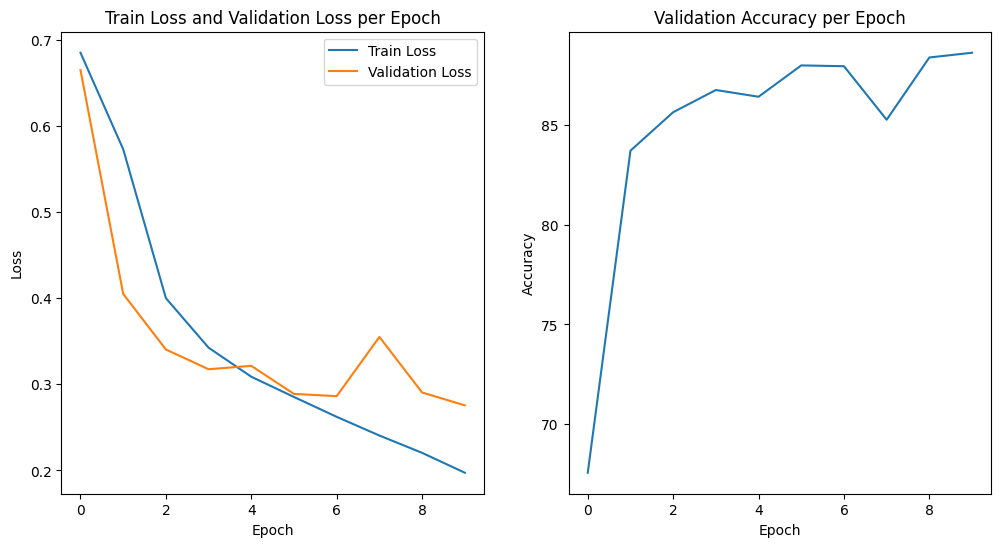

In [72]:
epoch_list = [x for x in range(epochs)]

plt.figure(figsize= (12,6))

plt.subplot((121))
plt.title('Train Loss and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_list, [x.item() for x in train_loss_per_epoch], label="Train Loss")
plt.plot(epoch_list, [x.item() for x in valid_loss_per_epoch], label="Validation Loss")
plt.legend()  # show labels

plt.subplot((122))
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_list, valid_acc_per_epoch)

plt.show()

In [73]:
import mlxtend, torchmetrics

mlxtend.__version__

'0.23.4'

In [74]:
from tqdm.auto import tqdm

#1. make predictions
y_preds = []
y_trues=[]
y_probs = []
model_02.eval()
wrong_count = 0

with torch.inference_mode():
  for inference_batch in tqdm(test_iter, desc='Making predictions...'#desciption
                  ):
    inference_batch_features, inference_batch_lengths = inference_batch.text
    inference_batch_labels = inference_batch.label


    y_logit = model_02(inference_batch_features, inference_batch_lengths)
    y_prob = torch.sigmoid(y_logit)
    y_pred = torch.round(y_prob)

    wrong_count += (y_pred.cpu() != inference_batch_labels.cpu()).sum().item()

    y_probs.append(y_prob.cpu())
    y_preds.append(y_pred.cpu())
    y_trues.append(inference_batch_labels.cpu())

  # print(y_preds)
  y_pred_tensor = torch.cat(y_preds)
  y_true_tensor = torch.cat(y_trues)
  y_prob_tensor = torch.cat(y_probs)  # shape [25000]

Making predictions...:   0%|          | 0/782 [00:00<?, ?it/s]

In [75]:
print(f"Total wrong predictions: {wrong_count} out of {len(y_true_tensor)}")

Total wrong predictions: 2628 out of 25000


In [76]:
print(train_label_field.vocab.itos)

['neg', 'pos']


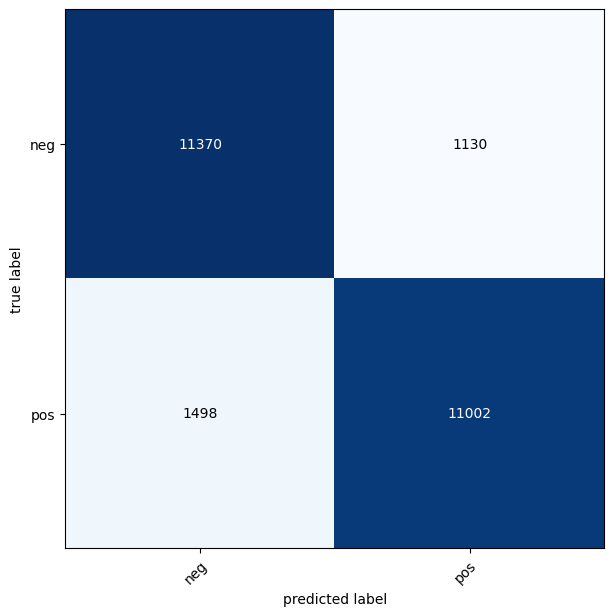

In [77]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = 2, task='binary')
confmat_tensor = confmat(
    preds = y_pred_tensor,
    target= y_true_tensor
)
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = train_label_field.vocab.itos,
                                figsize = (10,7))

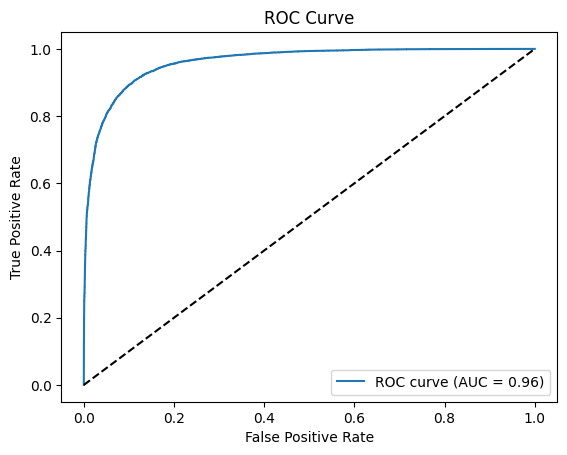

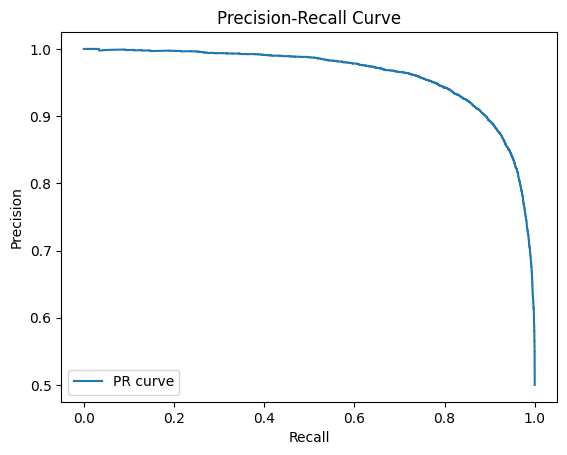

In [78]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# convert to numpy for sklearn
y_probs_np = y_prob_tensor.numpy()
y_true_np = y_true_tensor.numpy()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true_np, y_probs_np)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true_np, y_probs_np)
plt.figure()
plt.plot(recall, precision, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


# Functionizing Training and Inference

In [79]:
def train_step(model:torch.nn.Module,
               data_iter: torchtext.data.BucketIterator,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               train_loss_per_epoch,
               device: torch.device = device
           ):
    train_loss, train_acc = 0,0
    model.train()

    for batch_num, batch in enumerate(data_iter):

        train_batch_features, train_batch_lengths = batch.text
        train_batch_labels = batch.label

        pred_labels = model(train_batch_features.to(device), train_batch_lengths)

        loss = loss_fn(pred_labels, train_batch_labels.float())
        train_loss += loss
        train_acc +=accuracy_fn(y_true=train_batch_labels.float(), y_pred=torch.round(torch.sigmoid(pred_labels)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_loss /= len(data_iter) 
    train_acc /= len(data_iter)

    train_loss_per_epoch.append(train_loss)
    print(f'Train loss: {train_loss} | train acc: {train_acc}')

In [80]:
def valid_step(model:torch.nn.Module,
               data_iter: torchtext.data.BucketIterator,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               valid_loss_per_epoch,
               valid_acc_per_epoch,
               device: torch.device = device
           ):
    valid_loss, valid_acc = 0,0
    model.eval()

    with torch.inference_mode():
        for valid_batch in data_iter:

            valid_batch_features, valid_batch_lengths = valid_batch.text
            valid_batch_labels = valid_batch.label

            valid_pred = model(valid_batch_features.to(device), valid_batch_lengths)
            valid_loss += loss_fn(valid_pred, valid_batch_labels.float())
            valid_acc += accuracy_fn(y_true=valid_batch_labels.float(), y_pred=torch.round(torch.sigmoid(valid_pred)))

        valid_loss /= len(data_iter)
        valid_acc /= len(data_iter)

        valid_loss_per_epoch.append(valid_loss)
        valid_acc_per_epoch.append(valid_acc)
        print(f'valid loss: {valid_loss} | valid acc: {valid_acc}\n-----')


        return valid_loss.item()


In [81]:
def inference_mode(model:torch.nn.Module,
               data_iter: torchtext.data.BucketIterator,
               device: torch.device = device):
    y_preds=[]
    y_trues=[]
    y_probs=[]
    model.eval()

    with torch.inference_mode():
        for inference_batch in tqdm(data_iter, desc='Making predictions...'#desciption
                        ):
            inference_batch_features, inference_batch_lengths = inference_batch.text
            inference_batch_labels = inference_batch.label


            y_logit = model(inference_batch_features, inference_batch_lengths)
            y_prob = torch.sigmoid(y_logit)
            y_pred = torch.round(y_prob)

            y_probs.append(y_prob.cpu())
            y_preds.append(y_pred.cpu())
            y_trues.append(inference_batch_labels.cpu())

        # print(y_preds)
        y_pred_tensor = torch.cat(y_preds).long()
        y_true_tensor = torch.cat(y_trues).float()
        y_prob_tensor = torch.cat(y_probs).float()  # shape [25000]

        correct = (y_pred_tensor == y_true_tensor).sum().item()
        total = y_true_tensor.size(0)

        print(f"Correct predictions: {correct}/{total} ({correct/total:.2%})")

        return y_pred_tensor, y_true_tensor, y_prob_tensor

In [82]:
# --- Function 1: Epoch-based curves ---
def plot_epoch_metrics(epoch_list, train_loss_per_epoch, valid_loss_per_epoch, valid_acc_per_epoch):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss curves
    axes[0].plot(epoch_list, [x.item() for x in train_loss_per_epoch], label="Train Loss")
    axes[0].plot(epoch_list, [x.item() for x in valid_loss_per_epoch], label="Validation Loss")
    axes[0].set_title("Train/Validation Loss per Epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy curve
    axes[1].plot(epoch_list, valid_acc_per_epoch, label="Validation Accuracy", color="green")
    axes[1].set_title("Validation Accuracy per Epoch")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# --- Function 2: Inference-based metrics ---
def plot_inference_metrics(t_tensor, pred_tensor, prob_tensor, class_names):
    # --- Confusion Matrix ---
    confmat = ConfusionMatrix(num_classes=2, task="binary")
    confmat_tensor = confmat(preds=pred_tensor, target=t_tensor)

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(6,5)
    )
    plt.title("Confusion Matrix")
    plt.show()

    # --- ROC + Precision-Recall in one figure ---
    probs_np = prob_tensor.numpy()
    t_np = t_tensor.numpy()

    fpr, tpr, _ = roc_curve(t_np, probs_np)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(t_np, probs_np)

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # ROC curve
    axes[0].plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")
    axes[0].legend()

    # Precision-Recall curve
    axes[1].plot(recall, precision, label="PR curve")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()



# Upgrading Model_0

Here I will try to improve the model with increasing number of bi-lstm layers, adding some dropout, and making hidden_size easy to change

In [83]:
class Model_03(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super().__init__()
        #embed the index corresponding to the number
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=1) #added padding_idx = 1 to not affect gradient

        #feed batches into LSTM
        self.forward_and_backward_LSTM = nn.LSTM(input_size=300, #embedding dimension
                                    hidden_size=hidden_size, #hyperparameter 
                                    num_layers=2,
                                    bidirectional=True,
                                    batch_first=False,
                                    dropout=.5
                                    )

        self.classifier = nn.Sequential(
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=hidden_size*2*3),
                                        nn.Linear(in_features=hidden_size*2*3, out_features=hidden_size*2*3),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=1)
                                        nn.Linear(in_features=hidden_size*2*3, out_features=1)
                                        )
        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        #use pack_padded_sequence in order to make computation efficient
        packed_embedding = nn.utils.rnn.pack_padded_sequence(enforce_sorted=False, input=word_embedding, lengths=input_lengths.cpu())

        #pass through LSTM
        packed_output, (hn, cn) = self.forward_and_backward_LSTM(packed_embedding) #(seq_len, batch, hidden_size*2)
        
        #concatenate foward and backward hidden states
        h_final = torch.cat((hn[0], hn[1]), dim=1) # (batch_size, hidden_size*2)
        #Max and mean pooling
        unpacked_output, lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        mean_pool = torch.mean(unpacked_output, dim=0)
        max_pool, _ = torch.max(unpacked_output, dim=0)

        #combine
        features_pre_classification = torch.cat([h_final, mean_pool, max_pool], dim=1) #(batch_size, hidden_size*2*3)

        res = self.classifier(features_pre_classification).squeeze(dim=1)

        return res

In [84]:
model_03 = Model_03(embedding_matrix, hidden_size=256).to(device)

In [85]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_03.parameters(),
                            lr=0.05)
train_loss_per_epoch_03 = []
valid_loss_per_epoch_03 = []
valid_acc_per_epoch_03 = []

In [ ]:
from tqdm.auto import tqdm

#set seed
torch.manual_seed(42)
train_time_start_on_gpu = timer()

#set epochs small
epochs = 17

#create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'epoch: {epoch}')
  train_step(model_03, train_iter, loss_fn, optimizer, accuracy_fn, train_loss_per_epoch_03)
  valid_step(model_03, validation_iter, loss_fn, accuracy_fn, valid_loss_per_epoch_03, valid_acc_per_epoch_03)

train_time_end_on_gpu = timer()
total_train_time_model_03 = print_train_time(start= train_time_start_on_gpu,
                                              end = train_time_end_on_gpu,
                                              device = str(next(model_03.parameters()).device))


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 0
Train loss: 0.6896017789840698 | train acc: 54.39
valid loss: 0.6829383969306946 | valid acc: 58.47929936305732
-----
epoch: 1
Train loss: 0.6576758027076721 | train acc: 62.68
valid loss: 0.5877950191497803 | valid acc: 72.7109872611465
-----
epoch: 2
Train loss: 0.5655825734138489 | train acc: 70.575
valid loss: 0.5547212362289429 | valid acc: 70.16321656050955
-----
epoch: 3
Train loss: 0.49048054218292236 | train acc: 76.35
valid loss: 0.4603947103023529 | valid acc: 77.98566878980891
-----
epoch: 4
Train loss: 0.4124377965927124 | train acc: 81.365
valid loss: 0.35242030024528503 | valid acc: 84.97213375796179
-----
epoch: 5
Train loss: 0.36269333958625793 | train acc: 84.24
valid loss: 0.3742496073246002 | valid acc: 82.76273885350318
-----
epoch: 6
Train loss: 0.3322966992855072 | train acc: 85.845
valid loss: 0.3455345630645752 | valid acc: 84.47452229299363
-----
epoch: 7
Train loss: 0.31732285022735596 | train acc: 86.68
valid loss: 0.34969985485076904 | valid acc: 8

In [87]:
epoch_list_03 = [x for x in range(epochs)]

In [92]:
len(train_loss_per_epoch_03),len(valid_loss_per_epoch_03)

(17, 17)

In [91]:
y_pred_tensor_03, y_true_tensor_03, y_prob_tensor_03 = inference_mode(model_03,test_iter)

Making predictions...:   0%|          | 0/782 [00:00<?, ?it/s]

Correct predictions: 22255/25000 (89.02%)


In [93]:
len(epoch_list_03), len(train_loss_per_epoch_03), len(valid_loss_per_epoch_03), len(valid_acc_per_epoch_03)

(17, 17, 17, 17)

In [94]:
y_true_tensor_03.shape, y_pred_tensor_03.shape, y_prob_tensor_03.shape

(torch.Size([25000]), torch.Size([25000]), torch.Size([25000]))

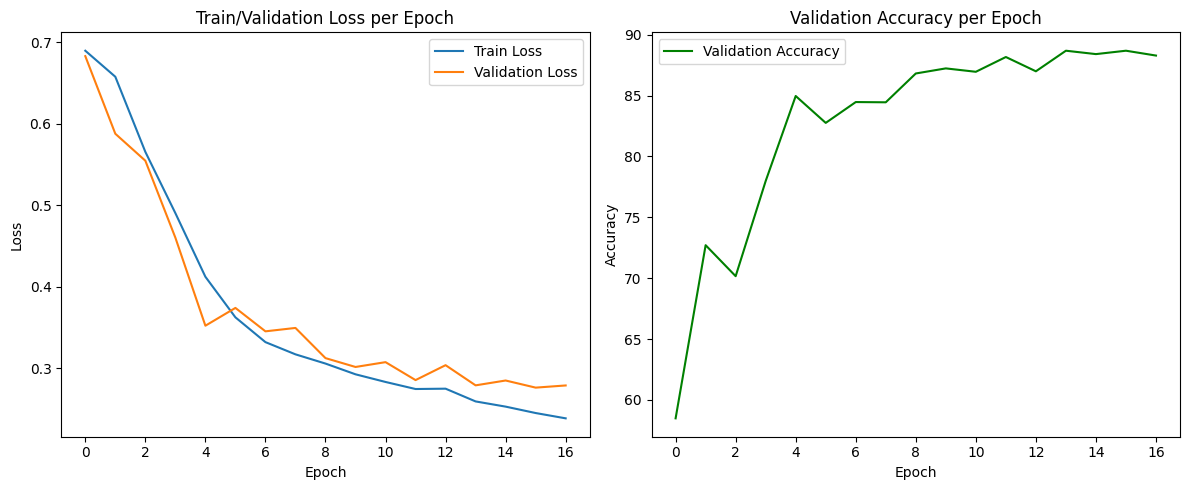

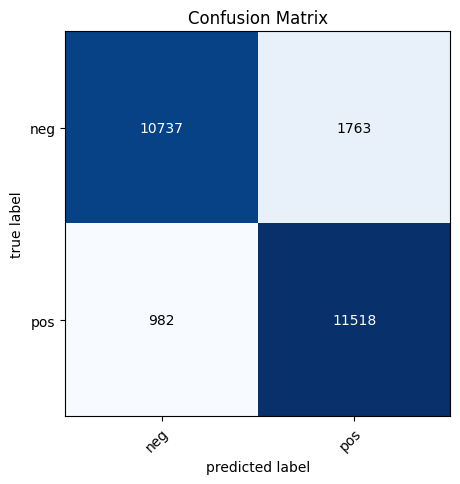

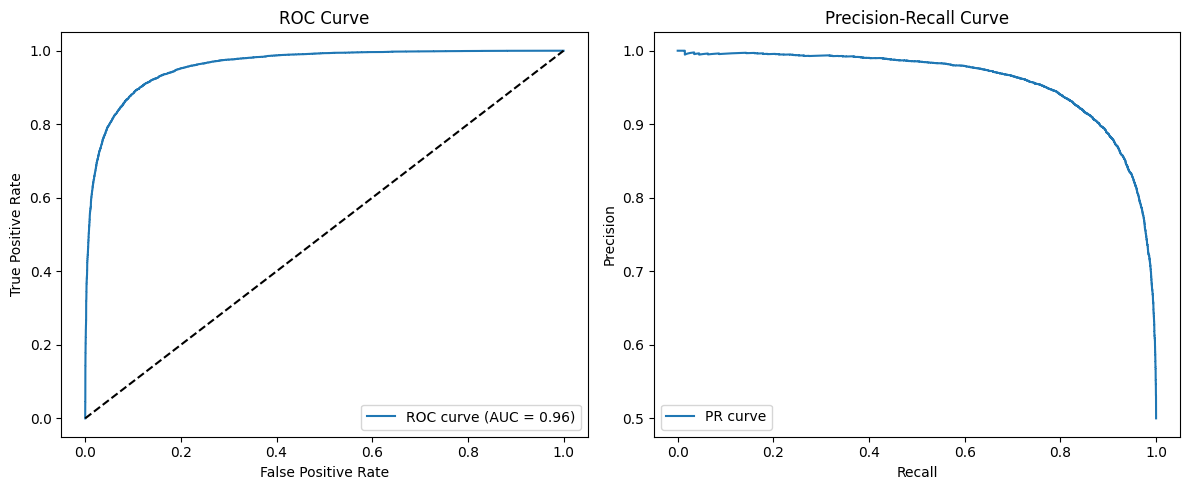

In [95]:
plot_epoch_metrics(epoch_list_03, train_loss_per_epoch_03, valid_loss_per_epoch_03, valid_acc_per_epoch_03)
plot_inference_metrics(y_true_tensor_03, y_pred_tensor_03, y_prob_tensor_03, class_names=train_label_field.vocab.itos)


# Model_1 (Adding in Attention Heads)

In [127]:
import gc

# Clear cache
torch.cuda.empty_cache()

# Collect garbage
gc.collect()


15264

In [97]:
class Model_1(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super().__init__()
        #embed the index corresponding to the number
        self.embedding = nn.Embedding.from_pretrained(embeddings=emb_matrix, freeze=True, padding_idx=1) #added padding_idx = 1 to not affect gradient

        #feed batches into LSTM
        self.forward_and_backward_LSTM = nn.LSTM(input_size=300, #embedding dimension
                                    hidden_size=hidden_size, #hyperparameter 
                                    num_layers=2,
                                    bidirectional=True,
                                    batch_first=False,
                                    dropout=.5
                                    )
        
        self.attention_head = nn.MultiheadAttention(embed_dim=hidden_size*2, 
                                                    num_heads=1, 
                                                    batch_first=False)

        self.classifier = nn.Sequential(
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=hidden_size*2*3),
                                        nn.Linear(in_features=hidden_size*2*4, out_features=hidden_size*2*4),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        # nn.Linear(in_features=hidden_size*2*3, out_features=1)
                                        nn.Linear(in_features=hidden_size*2*4, out_features=1)
                                        )
        
        

    def forward(self, input_indices, input_lengths):
        word_embedding = self.embedding(input_indices)
        #use pack_padded_sequence in order to make computation efficient
        packed_embedding = nn.utils.rnn.pack_padded_sequence(enforce_sorted=False, input=word_embedding, lengths=input_lengths.cpu())

        #pass through LSTM
        packed_output, (hn, cn) = self.forward_and_backward_LSTM(packed_embedding) #(seq_len, batch, hidden_size*2)
        
        
        #Max and mean pooling
        unpacked_output, lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        attention_output, attention_weights = self.attention_head(unpacked_output, unpacked_output, unpacked_output)


        h_final = torch.cat((hn[0], hn[1]), dim=1) # (batch_size, hidden_size*2)
        mean_pool = torch.mean(unpacked_output, dim=0)
        max_pool, _ = torch.max(unpacked_output, dim=0)
        attention_pool = torch.mean(attention_output, dim=0)

        #combine
        features_pre_classification = torch.cat([h_final, mean_pool, max_pool, attention_pool], dim=1) #(batch_size, hidden_size*2*3)

        res = self.classifier(features_pre_classification).squeeze(dim=1)

        return res

## Without Early Stopping

In [98]:
model_1 = Model_1(embedding_matrix, hidden_size=256).to(device)
model_1

Model_1(
  (embedding): Embedding(90636, 300, padding_idx=1)
  (forward_and_backward_LSTM): LSTM(300, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (attention_head): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [99]:
loss_fn_1 = nn.BCEWithLogitsLoss()
# optimizer_1 = torch.optim.AdamW(params=model_1.parameters(),
#                             lr=1e-4,
#                             weight_decay=1e-5)

optimizer_1 = torch.optim.Adam(params=model_1.parameters(),
                            lr=1e-3)
train_loss_per_epoch_1 = []
valid_loss_per_epoch_1 = []
valid_acc_per_epoch_1 = []

In [100]:
#set seed
torch.manual_seed(42)
train_time_start_on_gpu = timer()

#set epochs small
epochs_1 = 5

#create training and test loop
for epoch in tqdm(range(epochs_1)):
  print(f'epoch: {epoch}')
  train_step(model_1, train_iter, loss_fn_1, optimizer_1, accuracy_fn, train_loss_per_epoch_1)
  valid_step(model_1, validation_iter, loss_fn_1, accuracy_fn, valid_loss_per_epoch_1, valid_acc_per_epoch_1)


train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start= train_time_start_on_gpu,
                                              end = train_time_end_on_gpu,
                                              device = str(next(model_1.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0
Train loss: 0.38298502564430237 | train acc: 83.07
valid loss: 0.2903406620025635 | valid acc: 88.0374203821656
-----
epoch: 1
Train loss: 0.2664443552494049 | train acc: 89.305
valid loss: 0.377469927072525 | valid acc: 84.375
-----
epoch: 2
Train loss: 0.2272426187992096 | train acc: 91.215
valid loss: 0.24118734896183014 | valid acc: 90.18710191082802
-----
epoch: 3
Train loss: 0.1863405704498291 | train acc: 92.935
valid loss: 0.2706046998500824 | valid acc: 88.99283439490446
-----
epoch: 4
Train loss: 0.1513965129852295 | train acc: 94.36
valid loss: 0.2655612826347351 | valid acc: 90.04777070063695
-----
Train time on cuda:0: 192.422 seconds


In [103]:
print("Train time in seconds:",total_train_time_model_1)

Train time in seconds: 192.4220715999836


In [101]:
y_pred_tensor_1, y_true_tensor_1, y_prob_tensor_1 = inference_mode(model_1,test_iter)

Making predictions...:   0%|          | 0/782 [00:00<?, ?it/s]

Correct predictions: 22805/25000 (91.22%)


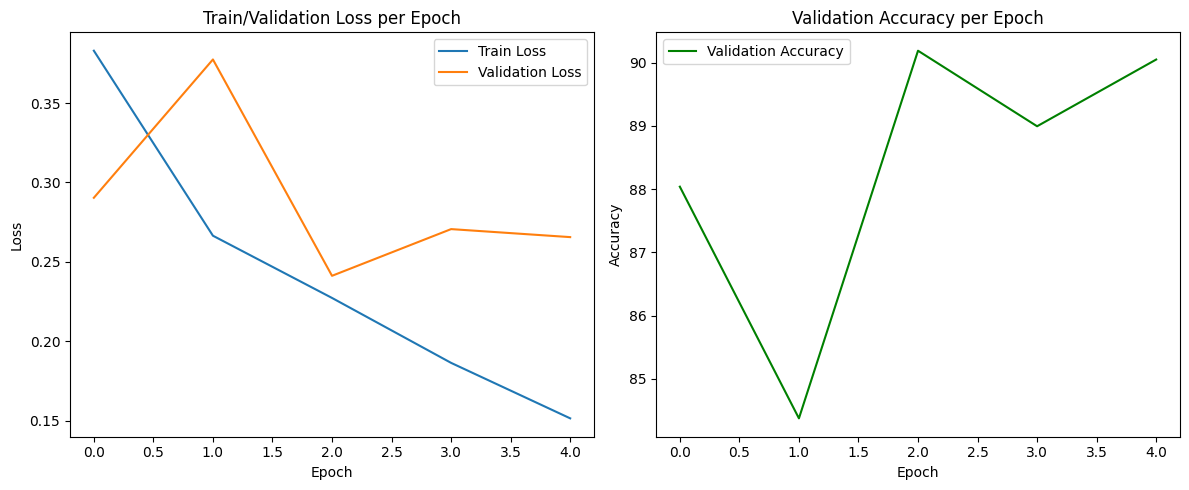

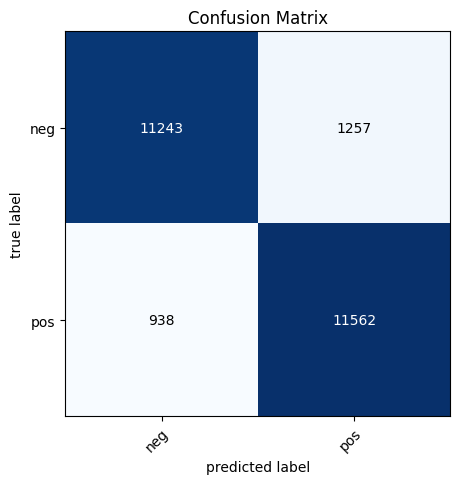

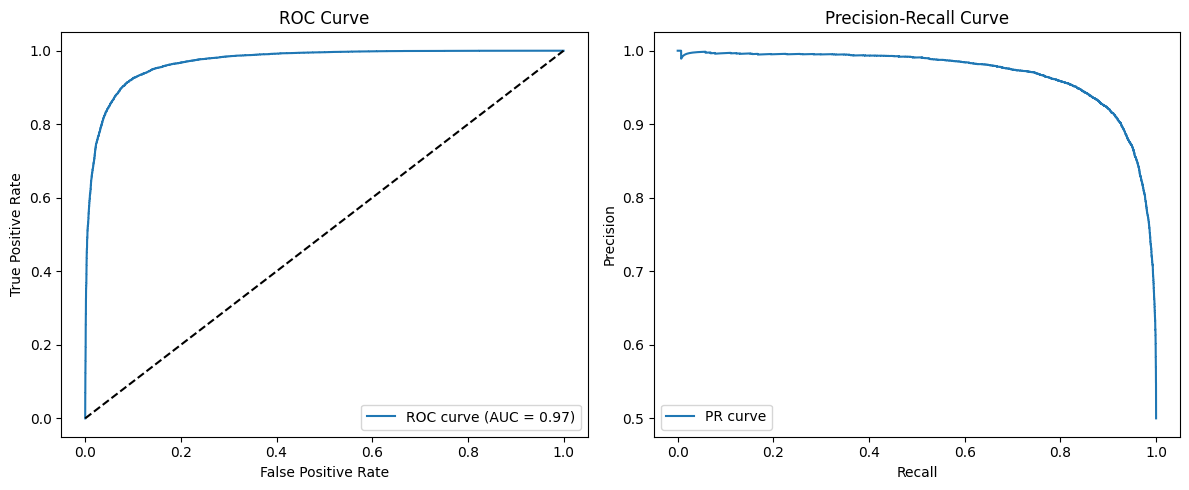

In [104]:
epoch_list_1 = [x for x in range(epochs_1)]
plot_epoch_metrics(epoch_list_1, train_loss_per_epoch_1, valid_loss_per_epoch_1, valid_acc_per_epoch_1)
plot_inference_metrics(y_true_tensor_1, y_pred_tensor_1, y_prob_tensor_1, class_names=train_label_field.vocab.itos)

## Adjusting Loop (early stopping)

### hidden_size = 512

In [107]:
model_11 = Model_1(embedding_matrix, hidden_size=512).to(device)

In [108]:
loss_fn_11 = nn.BCEWithLogitsLoss()
optimizer_11 = torch.optim.AdamW(params=model_11.parameters(),
                            lr=1e-4,
                            weight_decay=1e-5)


train_loss_per_epoch_11 = []
valid_loss_per_epoch_11 = []
valid_acc_per_epoch_11 = []

In [109]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_11, mode="min", factor=0.5, patience=1)


for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    train_step(model_11, train_iter, loss_fn_11, optimizer_11, accuracy_fn, train_loss_per_epoch_11)
    val_loss = valid_step(model_11, validation_iter, loss_fn_11, accuracy_fn, valid_loss_per_epoch_11, valid_acc_per_epoch_11)

    # 🔹 Scheduler step
    scheduler.step(val_loss)

    # 🔹 Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {k: v.clone() for k, v in model_11.state_dict().items()}
        print("✅ New best model saved (in memory)!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

train_time_end_on_gpu = timer()
total_train_time_model_11 = print_train_time(start= train_time_start_on_gpu,
                                              end = train_time_end_on_gpu,
                                              device = str(next(model_11.parameters()).device))


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.4018265902996063 | train acc: 81.145
valid loss: 0.32989123463630676 | valid acc: 85.76831210191082
-----
✅ New best model saved (in memory)!
Epoch 2/20
Train loss: 0.2979928255081177 | train acc: 87.59
valid loss: 0.29179808497428894 | valid acc: 87.97770700636943
-----
✅ New best model saved (in memory)!
Epoch 3/20
Train loss: 0.2710704505443573 | train acc: 88.855
valid loss: 0.28720471262931824 | valid acc: 88.57484076433121
-----
✅ New best model saved (in memory)!
Epoch 4/20
Train loss: 0.24837110936641693 | train acc: 89.94
valid loss: 0.28622567653656006 | valid acc: 88.4952229299363
-----
✅ New best model saved (in memory)!
Epoch 5/20
Train loss: 0.22696173191070557 | train acc: 90.96
valid loss: 0.2640957534313202 | valid acc: 89.29140127388536
-----
✅ New best model saved (in memory)!
Epoch 6/20
Train loss: 0.21189013123512268 | train acc: 91.71
valid loss: 0.29266610741615295 | valid acc: 87.69904458598727
-----
⚠️ No improvement. Patience: 1/2
Epoc

In [110]:
model_11.load_state_dict(best_model_state)

<All keys matched successfully>

In [111]:
saved_path = "BILSTM(512hs)_With_An_Attention_Head_2.pth"
torch.save(model_11.state_dict(), saved_path)
print(f"Model parameters saved to {saved_path}")

Model parameters saved to BILSTM(512hs)_With_An_Attention_Head_2.pth


In [112]:
y_true_tensor_11, y_pred_tensor_11, y_prob_tensor_11 = inference_mode(model_11,test_iter)

Making predictions...:   0%|          | 0/782 [00:00<?, ?it/s]

Correct predictions: 22558/25000 (90.23%)


In [113]:
len(train_loss_per_epoch_11), len(valid_loss_per_epoch_11), len(valid_acc_per_epoch_11)

(7, 7, 7)

7


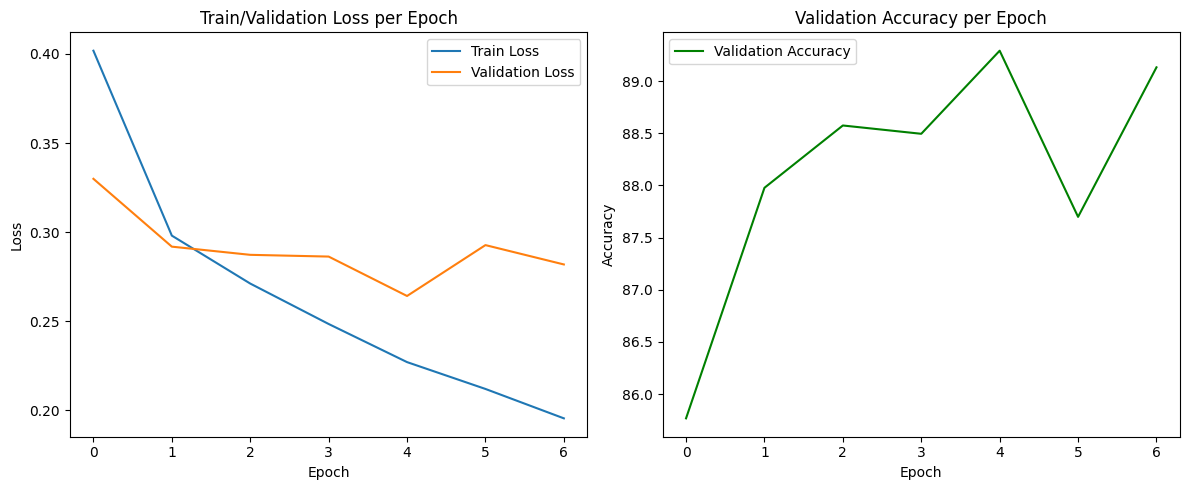

In [114]:
epoch_list_11 = [x for x in range(len(train_loss_per_epoch_11))]
print(len(epoch_list_11))
plot_epoch_metrics(epoch_list_11, train_loss_per_epoch_11, valid_loss_per_epoch_11, valid_acc_per_epoch_11)

For inference check Comparing_Models.ipynb

In [135]:
# plot_inference_metrics(y_true_tensor_11, y_pred_tensor_11, y_prob_tensor_11, class_names=train_label_field.vocab.itos)

### hidden_size = 256

In [116]:
import gc

# Clear cache
torch.cuda.empty_cache()

# Collect garbage
gc.collect()

16618

In [117]:
model_12 = Model_1(embedding_matrix, hidden_size=256).to(device)

In [118]:
loss_fn_12 = nn.BCEWithLogitsLoss()
optimizer_12 = torch.optim.AdamW(params=model_12.parameters(),
                            lr=1e-4,
                            weight_decay=1e-5)


train_loss_per_epoch_12 = []
valid_loss_per_epoch_12 = []
valid_acc_per_epoch_12 = []

In [119]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 20
best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_12, mode="min", factor=0.5, patience=1)


for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    train_step(model_12, train_iter, loss_fn_12, optimizer_12, accuracy_fn, train_loss_per_epoch_12)
    val_loss = valid_step(model_12, validation_iter, loss_fn_12, accuracy_fn, valid_loss_per_epoch_12, valid_acc_per_epoch_12)

    # 🔹 Scheduler step
    scheduler.step(val_loss)

    # 🔹 Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state_12 = {k: v.clone() for k, v in model_12.state_dict().items()}
        print("✅ New best model saved (in memory)!")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start= train_time_start_on_gpu,
                                              end = train_time_end_on_gpu,
                                              device = str(next(model_12.parameters()).device))


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train loss: 0.42184680700302124 | train acc: 79.335
valid loss: 0.3746368885040283 | valid acc: 83.67834394904459
-----
✅ New best model saved (in memory)!
Epoch 2/20
Train loss: 0.30390602350234985 | train acc: 87.445
valid loss: 0.31315162777900696 | valid acc: 86.72372611464968
-----
✅ New best model saved (in memory)!
Epoch 3/20
Train loss: 0.2764127850532532 | train acc: 88.82
valid loss: 0.2956414222717285 | valid acc: 87.93789808917198
-----
✅ New best model saved (in memory)!
Epoch 4/20
Train loss: 0.25865840911865234 | train acc: 89.35
valid loss: 0.27501651644706726 | valid acc: 88.37579617834395
-----
✅ New best model saved (in memory)!
Epoch 5/20
Train loss: 0.24096600711345673 | train acc: 90.315
valid loss: 0.2665770649909973 | valid acc: 89.29140127388536
-----
✅ New best model saved (in memory)!
Epoch 6/20
Train loss: 0.22518795728683472 | train acc: 91.07
valid loss: 0.2718508243560791 | valid acc: 89.15207006369427
-----
⚠️ No improvement. Patience: 1/2
Epo

In [120]:
model_12.load_state_dict(best_model_state_12)

<All keys matched successfully>

In [121]:
saved_path_12 = "BILSTM(256hs)_With_An_Attention_Head_2.pth"
torch.save(model_12.state_dict(), saved_path_12)
print(f"Model parameters saved to {saved_path_12}")

Model parameters saved to BILSTM(256hs)_With_An_Attention_Head_2.pth


In [122]:
y_true_tensor_12, y_pred_tensor_12, y_prob_tensor_12 = inference_mode(model_12,test_iter)

Making predictions...:   0%|          | 0/782 [00:00<?, ?it/s]

Correct predictions: 22585/25000 (90.34%)


In [123]:
(y_true_tensor_12.dtype, y_pred_tensor_12.dtype, y_prob_tensor_12.dtype),(y_true_tensor_1.dtype, y_pred_tensor_1.dtype, y_prob_tensor_1.dtype)

((torch.int64, torch.float32, torch.float32),
 (torch.float32, torch.int64, torch.float32))

In [124]:
len(train_loss_per_epoch_12), len(valid_loss_per_epoch_12), len(valid_acc_per_epoch_12)

(9, 9, 9)

9


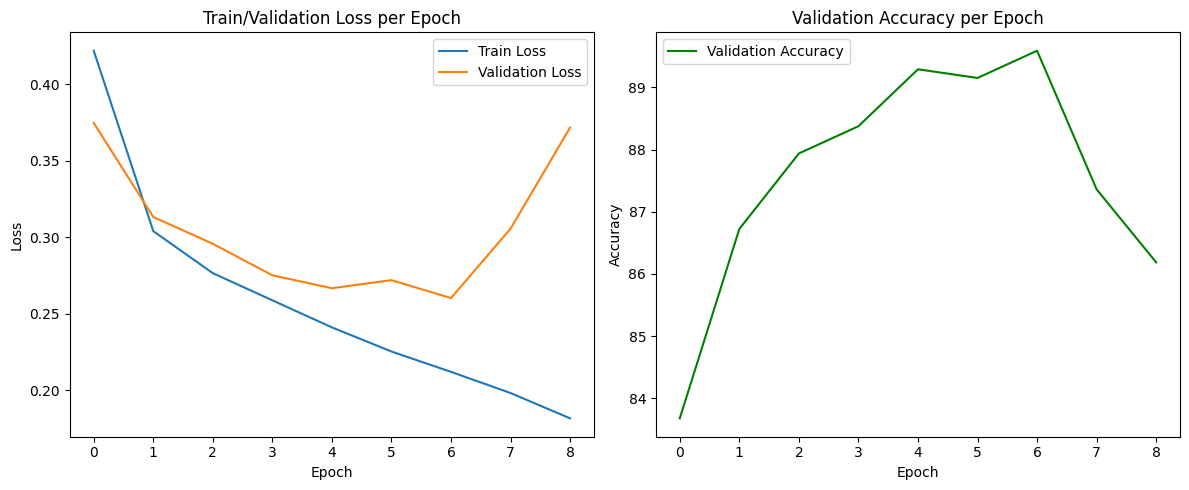

In [125]:
epoch_list_12 = [x for x in range(len(train_loss_per_epoch_12))]
print(len(epoch_list_12))
plot_epoch_metrics(epoch_list_12, train_loss_per_epoch_12, valid_loss_per_epoch_12, valid_acc_per_epoch_12)

For inference check Comparing_Models.ipynb

In [134]:
# plot_inference_metrics(y_true_tensor_12, y_pred_tensor_12, y_prob_tensor_12, class_names=train_label_field.vocab.itos)